In [1]:
# ============================== Loading Libraries ============================== #

import numpy as np
import pandas as pd
import random
import cv2
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# =============================================================================== #

In [2]:
# ======================= Specifying the Dataset Directory ====================== #

Dir_name = os.getcwd().replace("\\", "/") + "/Dataset/KDD1999/"     # Directory containing the dataset
Dataset_type = "noniid-#label1"                                     # Non-IID type

All_Dataset_File = "kdd.csv"                                        # Whole Dataset

Test_Dataset_File = "TestSet.csv"                                   # Test Dataset

# =============================================================================== #

In [3]:
# ============================== Dataset Parameters ============================= #

num_clients = 20       # Number of Clients
num_Features = 41      # Number of Features
num_Class = 20         # Number of Classes

# =============================================================================== #

In [4]:
# ============================= Algorithm Parameters ============================ #

lr = 0.001             # Learning Rate
explore_rate = 0.2     # Exploration Rate
ExR = 40               # Number of initial exploration rounds
UB1 = 20               # Lower Bound of the period where the exploration rate is decreased
UB2 = 40               # Upper Bound of the period where the exploration rate is decreased
P = 0.4                # Probability of exploration
epsilon = 3/4          # Exploration Rate Reduction Factor

# =============================================================================== #

In [5]:
# ============================= Experiment Parameters =========================== #

active_clients = 20    # Number of clients participating in each round
comms_round = 50       # Number of rounds
Batch_size = 100       # Batch size

# =============================================================================== #

In [7]:
# ==== Extracting the List of Labels from the Dataset and Encoding the Labels === #

Test_Dataset = pd.read_csv(Dir_name + All_Dataset_File )

y = Test_Dataset.iloc[:, num_Features]
encoder = LabelEncoder()
encoder.fit(y)   

# =============================================================================== #

LabelEncoder()

In [8]:
# ==================== Loading and Processing Client Datasets =================== #

clients = {}
clients_train = {}
clients_val = {}

DirList = os.listdir( Dir_name + Dataset_type + '/Train/')

# Create a list of client names
client_names = ['{}_{}'.format('client', i+1) for i in range(num_clients)]

for kk in range(1,num_clients+1):

    dataset = pd.read_csv(Dir_name + Dataset_type + '/Train/' + DirList[kk-1] )  

    X = dataset.iloc[:, 0:num_Features]
    y = dataset.iloc[:, num_Features]    

    # Encode the Labels
    y = encoder.transform(y)
    y = keras.utils.to_categorical(y, num_classes=num_Class )

    if X.shape[0] > 4 :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        X_train = X_val = X
        y_train = y_val = y

    clients[client_names[kk-1]] = list(zip(X_train.to_numpy(), y_train))
    clients_train[client_names[kk-1]] = tuple([X_train.to_numpy(), y_train])
    clients_val[client_names[kk-1]] = tuple([X_val.to_numpy(), y_val])

# =============================================================================== #

In [9]:
# ============================== Loading Test Data ============================== #

Test_Dataset = pd.read_csv(Dir_name + Dataset_type + "/" + Test_Dataset_File ) 

X_test = Test_Dataset.iloc[:, 0:num_Features]
y_test = Test_Dataset.iloc[:, num_Features]

y_test = encoder.transform(y_test)
y_test = keras.utils.to_categorical(y_test , num_classes=num_Class )

# =============================================================================== #

In [10]:
# ======= Creating a TensorFlow Dataset (TFDS) from a Client's Data Shard ======= #

def batch_data(data_shard, bs=Batch_size):
    
    # Seperate shard into data and labels lists
    data, label = zip(*data_shard)
    
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

# =============================================================================== #

In [11]:
# ========================= Processing and Batching Data ======================== #

# Process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

# Process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

del clients

# =============================================================================== #

In [12]:
# ============================== Defining the Model ============================= #

class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(300, input_shape=(shape,) , activation='relu'))
        model.add(Dense(200, activation = 'relu'))
        model.add(Dense(num_Class, activation='softmax'))
        return model

# =============================================================================== #

In [13]:
# ========================= Defining Optimization method ======================== #

loss='categorical_crossentropy'
metrics = ['accuracy']

optimizer = tf.keras.optimizers.legacy.Nadam(lr=lr)

# =============================================================================== #

In [14]:
# ======================= Calculating weights for scaling ======================= #

def weight_scalling_factor(clients_trn_data, client_name):
    
    client_names = list(clients_trn_data.keys())
    
    # Get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    
    # First calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    
    # Get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    return local_count/global_count

# =============================================================================== #

In [15]:
# ============================ Scaling model weights ============================ #

def scale_model_weights(weight, scalar):
    
    weight_final = []
    
    steps = len(weight)
    
    for i in range(steps):
        weight_final.append(scalar * weight[i])
        
    return weight_final

# =============================================================================== #

In [16]:
# ======================= Calculating sum of scaled weights ===================== #

def sum_scaled_weights(scaled_weight_list):
    
    avg_grad = list()
    
    # Get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

# =============================================================================== #

In [17]:
# ====================== Testing the model on the test set ====================== #

def test_model(X_test, Y_test,  model, comm_round):
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    logits = model.predict(X_test)
    
    loss = cce(Y_test, logits)
    
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))

    Macro_Avg_F1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1), average='macro')

    print('Communication Round: {} | acc: {:.3%} | MacroAvgF1: {} | loss: {}'.format(comm_round, acc, Macro_Avg_F1 , loss))
    return acc, loss

# =============================================================================== #

In [18]:
# ============== Testing the model on the client's validation set =============== #

def test_model_val(X_test, Y_test,  model, comm_round):
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    logits = model.predict(X_test , verbose = 0)
    
    loss = cce(Y_test, logits)
    
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))

    return acc, loss

# =============================================================================== #

In [19]:
# ========================= Federated Learning Process ========================== #

# Initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(num_Features, num_Class)
Best_model = smlp_global.build(num_Features, num_Class)

global_acc_list = []
global_precision_list = []
global_recall_list = []

Best_Acc = 0
Best_Weights = []

client_names= list(clients_batched.keys())

# Commence global training loop
for comm_round in range(comms_round):

    Accuracy_List = []

    # Get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    # Initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    # Randomly selecting clients to participate in the current round.
    selected_clients = random.sample(client_names, k = active_clients)
    clients_batched_subset = {key: clients_batched[key] for key in selected_clients if key in clients_batched}

    # loop through each client and create new local model
    for client in selected_clients:

        smlp_local = SimpleMLP()
        local_model = smlp_local.build(num_Features, num_Class)
        local_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)


        [acc1 , Loss1] = test_model_val(clients_train[client][0], clients_train[client][1], global_model, comm_round)
    

        if (comm_round < ExR) or (random.random() < P):

            if (comm_round > UB1 ) and (comm_round < UB2):
                explore_rate = explore_rate * epsilon


            History = local_model.fit(clients_batched[client], epochs=10, verbose=0)

            scaling_factor = -1.0
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            Difference_Weight = sum_scaled_weights([ global_weights ,  scaled_weights  ])


            yy = [ x * explore_rate * 1.0 for x in Difference_Weight ]
            Mean_Weight = sum_scaled_weights([  global_weights  ,  yy  ])
            local_model.set_weights(Mean_Weight)


            History = local_model.fit(clients_batched[client], epochs=10, verbose=0)
            acc2 = History.history['accuracy'][len(History.history['accuracy'])-1]

            if acc1 <= acc2 :
                Local_weight = local_model.get_weights()
                Final_Local_Model = local_model
                Acc = acc2                
            else:
                Local_weight = global_weights
                Final_Local_Model = global_model
                Acc = acc1               
        else:

            local_model.set_weights(global_weights)
            local_model.fit(clients_batched[client], epochs=10, verbose=0)
            Local_weight = local_model.get_weights()

        # Scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched_subset, client)
        scaled_weights = scale_model_weights(Local_weight , scaling_factor)
        scaled_local_weight_list.append(scaled_weights)


        # Clear session to free memory after each communication round
        K.clear_session()

    # To get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    # Update global model
    global_model.set_weights(average_weights)


    # Calculating the validation accuracy
    for client in client_names:
        Val_Acc, Val_loss = test_model_val(clients_val[client][0], clients_val[client][1], global_model, comm_round)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_acc = Val_Acc * scaling_factor
        Accuracy_List.append(scaled_acc)

    average_acc = sum(Accuracy_List)                                   


    # Check if the new weights are better than the previous global weights based on accuracy on training samples.
    if average_acc > Best_Acc :                                                        
        Best_Weights = global_model.get_weights()                                      
        Best_Acc = average_acc                                                         
        Best_model.set_weights(Best_Weights)                                           


    # Test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:

        global_acc, global_loss = test_model(X_test, Y_test, Best_model, comm_round) 
        global_acc_list.append(global_acc)

        y_pred = Best_model.predict(X_test)

        global_precision = precision_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4])
        global_precision_list.append(global_precision)

        global_recall = recall_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4])
        global_recall_list.append(global_recall)
        
# =============================================================================== #

123/123 [==============================] - 1s 3ms/step
Communication Round: 0 | acc: 12.784% | MacroAvgF1: 0.012594775687045014 | loss: 2.9387829303741455
123/123 [==============================] - 1s 4ms/step
Communication Round: 1 | acc: 23.702% | MacroAvgF1: 0.064970707635462 | loss: 2.8355274200439453
123/123 [==============================] - 0s 2ms/step
Communication Round: 2 | acc: 38.021% | MacroAvgF1: 0.10433891881765617 | loss: 2.7054104804992676
123/123 [==============================] - 0s 3ms/step
Communication Round: 3 | acc: 38.021% | MacroAvgF1: 0.10433891881765617 | loss: 2.7054104804992676
123/123 [==============================] - 0s 2ms/step
Communication Round: 4 | acc: 38.174% | MacroAvgF1: 0.13476842868576513 | loss: 2.7025644779205322
123/123 [==============================] - 0s 2ms/step
Communication Round: 5 | acc: 40.936% | MacroAvgF1: 0.19761257811799596 | loss: 2.656005620956421
123/123 [==============================] - 0s 3ms/step
Communication Round: 6 

In [20]:
# ================================ Test Report ================================== #

res = classification_report(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1) , digits=4 )

print(res)

# =============================================================================== #

              precision    recall  f1-score   support

           0     0.9779    0.9740    0.9760       500
           1     0.0000    0.0000    0.0000        22
           2     0.0000    0.0000    0.0000         3
           3     0.0000    0.0000    0.0000       500
           4     0.0000    0.0000    0.0000         1
           5     0.6981    0.9673    0.8110       306
           6     0.0000    0.0000    0.0000         9
           7     0.0000    0.0000    0.0000         2
           8     0.0000    0.0000    0.0000        18
           9     0.8547    1.0000    0.9217       500
          10     1.0000    0.0119    0.0235        84
          11     0.4589    0.9820    0.6255       500
          12     0.0000    0.0000    0.0000        87
          13     0.9919    0.6949    0.8173       354
          14     0.0000    0.0000    0.0000        13
          15     0.8971    0.9940    0.9431       500
          16     0.9785    1.0000    0.9891       500
          17     0.6667    

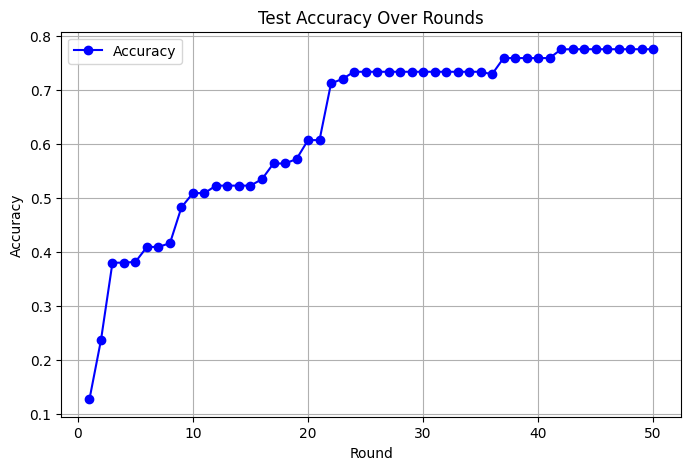

In [21]:
# ======================= Change Curve for Test Accuracy ======================== #

rounds = range(1, len(global_acc_list) + 1) 

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(rounds, global_acc_list, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Test Accuracy Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# =============================================================================== #